In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import *
from minibatch import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
dataset = get_dataset(type="64")

Total number of images in dataset5:  65774


In [3]:
train_data, train_label_onehot, validation_data, validation_label_onehot, test_data, test_label_onehot \
    = split_train_validation_test(dataset)  

Train data size:  50779
Train label size:  50779
Validation data size:  10000
Validation label size:  10000
Test data size:  4995
Test label size:  4995


In [4]:
X_validation, y_validation = get_data(validation_data, validation_label_onehot)
print(X_validation.shape)

(10000, 64, 64, 3)


In [5]:
X_train, y_train = get_data(train_data, train_label_onehot)
print(X_train.shape)

(50779, 64, 64, 3)


In [6]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [20]:
def get_mini_batches(data, label, batch_size = 128):
    shuffle_in_unison(data, label)
    n = len(data)
    mini_batches = [(data[k:k+batch_size], label[k:k+batch_size]) for k in range(0, n, batch_size)]
    return mini_batches


In [26]:
#test minibatch
mini_batches = get_mini_batches(X_train, y_train)
print(len(mini_batches))


397


array([[[[ -61.30249023,  -51.74462891,  -19.69897461],
         [ -68.30249023,  -56.74462891,  -33.69897461],
         [ -68.30249023,  -56.74462891,  -51.69897461],
         ..., 
         [ -70.30249023,  -60.74462891,  -53.69897461],
         [ -71.30249023,  -62.74462891,  -43.69897461],
         [ -72.30249023,  -66.74462891,  -56.69897461]],

        [[ -72.30249023,  -56.74462891,  -49.69897461],
         [ -67.30249023,  -55.74462891,  -51.69897461],
         [ -62.30249023,  -57.74462891,  -54.69897461],
         ..., 
         [ -57.30249023,  -57.74462891,  -48.69897461],
         [ -58.30249023,  -60.74462891,  -33.69897461],
         [ -63.30249023,  -60.74462891,  -46.69897461]],

        [[ -73.30249023,  -56.74462891,  -65.69897461],
         [ -77.30249023,  -56.74462891,  -60.69897461],
         [ -54.30249023,  -71.74462891,  -64.69897461],
         ..., 
         [ -52.30249023,  -58.74462891,  -47.69897461],
         [ -53.30249023,  -61.74462891,  -45.69897461],

#  neural network

In [12]:
from minibatch import *

import tensorflow as tf

print("(WIDTH, HEIGHT)=",(WIDTH,HEIGHT))
C = 24

X = tf.placeholder(tf.float32, [None, WIDTH, HEIGHT, 3])
Y_ = tf.placeholder(tf.float32, [None, C])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)

D = WIDTH*HEIGHT*3 #120*120*3
L = 100

# Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

# Weights initialised with small random values

W1 = tf.Variable(tf.truncated_normal([D, L], stddev=0.01))  # 784 = 28 * 28
B1 = tf.Variable(tf.ones([L])/100)

W2 = tf.Variable(tf.truncated_normal([L, C], stddev=0.1))
B2 = tf.Variable(tf.zeros([C]))

XX = tf.reshape(X, [-1, D])

Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
#Y1d = tf.nn.dropout(Y1, pkeep)

Ylogits = tf.matmul(Y1, W2) + B2


# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
softmax = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(softmax)

gamma = 10.0
reg = gamma*tf.nn.l2_loss(W1)


total_loss = cross_entropy + reg

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(total_loss)

saver =tf.train.Saver()


(WIDTH, HEIGHT)= (64, 64)


In [13]:
import time
BATCH_SIZE = 128
EPOCHS = 300

X_use = X_train
y_use = y_train

In [15]:
train_losses = []
train_accuracies = []
validation_accuracies = []

#Initialisation
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    lr = 0.0001

    for k in range(EPOCHS):
        print("--------------------------")
        
        if lr > 0.00001:
            lr *= 0.99
            
        print(k, ": ", "learning rate = ", lr)
        mini_batches = get_mini_batches(X_use, y_use, batch_size = BATCH_SIZE)
        
        i = 0
        
        
        for mini_batch in mini_batches:
            # load batch of images and correct answers

            batch_X, batch_Y = mini_batch
            
            sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, learning_rate: lr, pkeep: 1.0})

            if i >= 0 and i % 100 == 0:
                cross_entropy_loss, reg_loss = sess.run([cross_entropy, reg], feed_dict={X: batch_X, Y_: batch_Y,  pkeep: 1.0})
                loss = cross_entropy_loss + reg_loss
                train_losses.append(loss)             
                print(i, ":", " cross entropy loss = ", cross_entropy_loss, "; reg = ", reg_loss)            
            i+= 1
            
        #saver.save(sess, "./tmp/one_layer/model_image64_adam.ckpt")
    
        train_accuracy = sess.run(accuracy, feed_dict={X: X_use[:10000], Y_:y_use[:10000],  pkeep: 1.0})
        validation_accuracy = sess.run(accuracy, feed_dict={X: X_validation, Y_: y_validation, pkeep: 1.0})
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
    
        print(k, ": train_accuracy: ", train_accuracy, "; validation_accuracy: ", validation_accuracy)
   
    # Save the variables to disk.
    save_path = saver.save(sess, "./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt")
    print("Model saved in file: %s" % save_path)

--------------------------
0 :  learning rate =  9.900000000000001e-05
0 :  cross entropy loss =  35.4232 ; reg =  473.421
100 :  cross entropy loss =  3.44631 ; reg =  226.632
200 :  cross entropy loss =  2.37341 ; reg =  81.9355
300 :  cross entropy loss =  1.88772 ; reg =  27.2181
0 : train_accuracy:  0.4185 ; validation_accuracy:  0.4253
--------------------------
1 :  learning rate =  9.801e-05
0 :  cross entropy loss =  1.86701 ; reg =  9.76956
100 :  cross entropy loss =  2.08194 ; reg =  4.07212
200 :  cross entropy loss =  1.4526 ; reg =  2.38397
300 :  cross entropy loss =  1.40969 ; reg =  1.80135
1 : train_accuracy:  0.4146 ; validation_accuracy:  0.4135
--------------------------
2 :  learning rate =  9.70299e-05
0 :  cross entropy loss =  1.78007 ; reg =  1.79228
100 :  cross entropy loss =  1.58101 ; reg =  1.5874
200 :  cross entropy loss =  1.62744 ; reg =  1.71392
300 :  cross entropy loss =  1.50392 ; reg =  1.60301
2 : train_accuracy:  0.4906 ; validation_accuracy: 

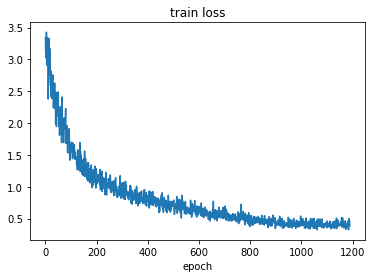

In [16]:
plt.plot(train_losses[10:])
plt.title("train loss")
plt.xlabel("epoch")

(0.2, 1)

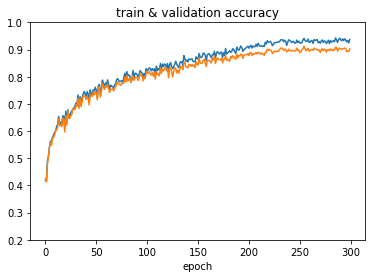

In [17]:
plt.plot(train_accuracies, label="train")
plt.plot(validation_accuracies, label="validation")
plt.title("train & validation accuracy")
plt.xlabel("epoch")
plt.ylim([0.2,1])

In [39]:
def compute_accuracy(data, label, model_path):
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model_path)
        print("Model restored.")
        N = len(data)    
        batch_size = 128
        sum_correct = 0.
        mini_batches = [(data[k:k+batch_size], label[k:k+batch_size]) for k in range(0, N, batch_size)]
            
        for mini_batch in mini_batches:
            batch_X, batch_Y = mini_batch
            n = batch_X.shape[0]
            a = sess.run(accuracy, feed_dict={X: batch_X, Y_: batch_Y, pkeep:1.0})
            sum_correct += a*n
        
        test_accuracy = sum_correct/N
        print("accuracy = ", test_accuracy)
        

In [36]:
compute_accuracy(X_train, y_train, "./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt
Model restored.
accuracy =  0.943933515828


In [37]:
compute_accuracy(X_validation, y_validation, "./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt
Model restored.
accuracy =  0.9026


In [40]:
def test_accuracy(model_path):
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model_path)
        print("Model restored.")
        N = len(test_data)    
        batch_size = 128
        batch_number = int(N/batch_size) + 1
        sum_correct = 0.
        for i in range(batch_number):
            batch_X, batch_Y = get_batch(test_data, test_label_onehot, i)
            n = batch_X.shape[0]
            a = sess.run(accuracy, feed_dict={X: batch_X, Y_: batch_Y})
            sum_correct += a*n
        
        test_accuracy = sum_correct/N
        print("final test accuracy = ", test_accuracy)

test_accuracy( "./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt
Model restored.
final test accuracy =  0.905305305305


## Final Result
- 2 layer
- regularlization = 0.5
- batch 128
- 200 epoches

### Test accuracy = 0.94

- regularlization = 1.0
- batch 128
- 500 epoches

### Test accuracy = 0.941867655895

- regularlization = 5.0
- batch 128
- 500 epoches

### Test accuracy = 0.926716140707

In [43]:
def predict(model_path):
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model_path)
        print("Model restored.")
        
        example_X, example_y = get_data(test_data[:20], test_label_onehot[:20])
        
        prediction, true_labels = sess.run([tf.argmax(Ylogits, 1), tf.argmax(Y_, 1)], feed_dict={X: example_X, Y_: example_y})
        
        return prediction, true_labels

prediction, true_labels = predict( "./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt
Model restored.


In [44]:
prediction

array([ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [45]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
from PIL import Image
examples = test_data[0:20]

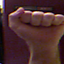

In [52]:
Image.open(examples[0])

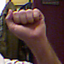

In [53]:
Image.open(examples[1])

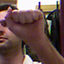

In [54]:
Image.open(examples[2])

In [58]:
def confusion_matrix(model_path):
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model_path)
        print("Model restored.")
        N = len(test_data)    
        batch_size = 128
        batch_number = int(N/batch_size) + 1
        predictions = []
        true_labels = []
        for i in range(batch_number):
            batch_X, batch_Y = get_batch(test_data, test_label_onehot, i)
            prediction_, true_label_ = sess.run([tf.argmax(Ylogits, 1), tf.argmax(Y_, 1)], feed_dict={X: batch_X, Y_: batch_Y})
            predictions.extend(prediction_)
            true_labels.extend(true_label_)
        
        return predictions, true_labels

predictions, true_labels = confusion_matrix( "./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/two_layer_new_split/adam_reg10_lr0001_epoch300.ckpt
Model restored.


In [70]:
confusion_mat = np.zeros((C, C ))
for i in range(len(test_data)):
    confusion_mat[predictions[i], true_labels[i]] += 1

In [78]:
confusion_mat[:,11]

array([   0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    1.,
          0.,    0.,  189.,    5.,    2.,    0.,    1.,    0.,    5.,
          1.,    0.,    0.,    0.,    0.,    1.])

In [77]:
letters.index('m')

11

In [82]:
letters[12]

'n'

In [83]:
confusion_mat[:,12]

array([   0.,    0.,    0.,    0.,    2.,    0.,    0.,    1.,    0.,
          0.,    0.,    9.,  180.,    1.,    0.,    0.,    0.,    1.,
          7.,    0.,    0.,    0.,    1.,    2.])

In [86]:
confusion_mat[4,:]

array([   0.,    0.,    3.,    1.,  188.,    1.,    0.,    0.,    0.,
          0.,    0.,    0.,    2.,    6.,    0.,    1.,    0.,    4.,
          0.,    0.,    0.,    0.,    0.,    1.])

In [100]:
confuse_e_o = [i for i in range(len(test_data)) if predictions[i] == 4 and true_labels[i] == 13]
correct_e = [i for i in range(len(test_data)) if predictions[i] == 4 and true_labels[i] == 4]
correct_o = [i for i in range(len(test_data)) if predictions[i] == 13 and true_labels[i] == 13]

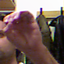

In [91]:
Image.open(test_data[confuse_e_o[0]])

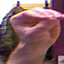

In [93]:
Image.open(test_data[confuse_e_o[1]])

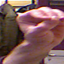

In [94]:
Image.open(test_data[confuse_e_o[2]])

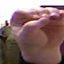

In [95]:
Image.open(test_data[confuse_e_o[3]])

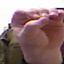

In [96]:
Image.open(test_data[confuse_e_o[4]])

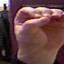

In [97]:
Image.open(test_data[confuse_e_o[5]])

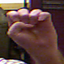

In [99]:
Image.open(test_data[correct_e[0]])

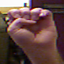

In [101]:
Image.open(test_data[correct_e[1]])

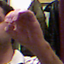

In [102]:
Image.open(test_data[correct_o[0]])

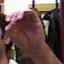

In [103]:
Image.open(test_data[correct_o[1]])

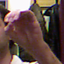

In [104]:
Image.open(test_data[correct_o[2]])

In [109]:
[test_data[p] for p in confuse_e_o]

['./datasets/dataset5_64/A/o/color_14_0261.png',
 './datasets/dataset5_64/D/o/color_14_0192.png',
 './datasets/dataset5_64/D/o/color_14_0443.png',
 './datasets/dataset5_64/E/o/color_14_0234.png',
 './datasets/dataset5_64/E/o/color_14_0231.png',
 './datasets/dataset5_64/E/o/color_14_0404.png']

In [113]:
np.savetxt("./confusion_matrix.csv", confusion_mat, delimiter=",") 